# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.042361,True,4.579060
1,-0.847122,True,1.415021
2,0.906402,False,2.066497
3,0.022312,True,4.834683
4,-0.554359,True,2.421440
...,...,...,...
995,0.615774,True,6.914126
996,-1.683696,False,-5.719522
997,1.039762,True,8.583192
998,-0.887531,True,1.832510


<Axes: xlabel='v0'>

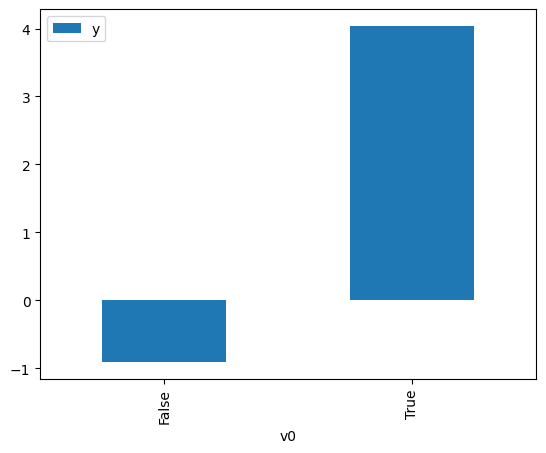

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

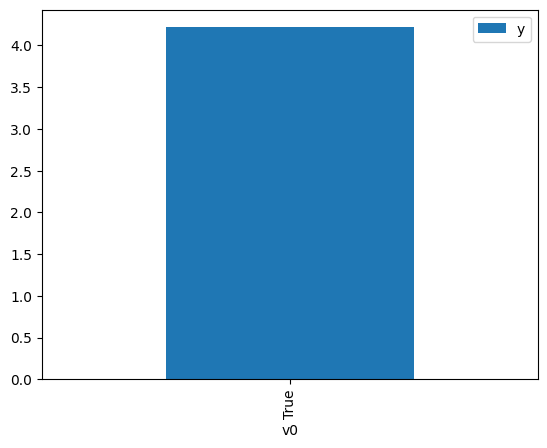

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.015853,False,-0.188116,0.504615,1.981710
1,-1.729101,False,-3.794273,0.702771,1.422938
2,-0.946089,False,-3.552992,0.616726,1.621465
3,1.401779,False,3.224941,0.336638,2.970553
4,-1.096269,False,-2.116055,0.634017,1.577244
...,...,...,...,...,...
995,-1.536143,False,-3.109520,0.682588,1.465013
996,0.495679,False,1.098077,0.442022,2.262332
997,-1.332220,False,-5.698594,0.660486,1.514036
998,0.471732,False,1.435870,0.444927,2.247562


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.746065,True,-0.372210,0.295490,3.384212
1,-0.756293,True,2.239578,0.405551,2.465784
2,0.834249,True,7.204241,0.598536,1.670742
3,-0.347932,True,1.634831,0.454705,2.199229
4,0.967702,True,8.417079,0.614191,1.628158
...,...,...,...,...,...
995,0.209915,True,5.496323,0.523110,1.911643
996,0.209915,True,5.496323,0.523110,1.911643
997,0.177552,True,6.457450,0.519141,1.926261
998,-1.710444,True,-0.037843,0.299147,3.342833


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9426.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):                        0.00
Time:                        19:34:38   Log-Likelihood:                         -1413.6
No. Observations:                1000   AIC:                                      2831.
Df Residuals:                     998   BIC:                                      2841.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7566      0.031     87.909      0.000       2.695       2.818
x2             4.9654      0.046    107.623      0.000       4.875       5.056
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                1.313
Skew:                          -0.065   Prob(JB):                        0.519
Kurtosis:                       3.120   Cond. No.                         1.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""